In [5]:
!pip install sncosmo

In [6]:
!pip install iminuit

In [7]:
!pip install ipympl


In [8]:
import time
import os
import subprocess

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sncosmo
from astropy.table import Table

from sklearn.preprocessing import StandardScaler 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib widget

In [11]:
data_root = r'C:\Users\Alcatraz\Desktop\Supernova\SupernovaData\data\supernovae_data'

In [16]:
lc_file = os.path.join(data_root, '2.dat')
lc = Table.read(lc_file, format='ascii')
lc

mjd,filter,flux,flux_error,zp,zpsys
float64,str4,float64,float64,float64,str2
0.0,desg,6.266,4.792,27.5,ab
0.01600000000325963,desr,14.55,5.344,27.5,ab
0.031000000002677552,desi,11.24,5.442,27.5,ab
0.06199999999807915,desz,13.12,4.698,27.5,ab
2.0,desg,4.891,2.246,27.5,ab
2.139999999999418,desr,20.78,3.059,27.5,ab
2.1560000000026776,desi,15.44,4.212,27.5,ab
2.186999999998079,desz,15.36,3.53,27.5,ab
9.984000000004016,desg,2.422,1.708,27.5,ab


In [17]:
def fit_supernova(lc):
    """
    Small function to fit a light curve with the SALT2 model, using sncosmo and iminuit.
    
    Parameters
    -----------
    lc : astropy.table.Table
        Light curve (in the format sncosmo expects)
    
    Returns
    ----------
    z, t0, x0, x1, c
        Best-fitting parameters of the model
    """
    bnds = {'z':(0.01, 1.5), 't0':(-100,100),'x0':(-1e-3, 1e-3), 'x1':(-3, 3), 'c':(-0.5, 0.5)}
    mod = sncosmo.Model('salt2-extended')
    res = sncosmo.fit_lc(lc, mod, vparam_names=mod.param_names, bounds=bnds, minsnr=0)
    return res[0].parameters

In [18]:
prms = fit_supernova(lc)
print('Best fitting SALT2 parameters: [z, t0, x0, x1, c]:')
print(prms)

Best fitting SALT2 parameters: [z, t0, x0, x1, c]:
[7.26464642e-01 1.74121192e+01 1.69731776e-06 2.99999990e+00
 1.98672564e-01]


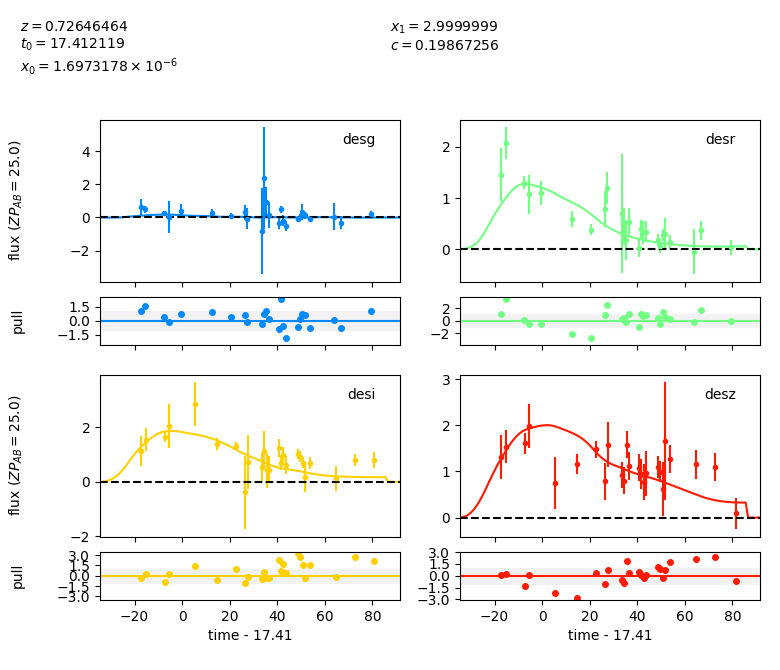

In [19]:
mod = sncosmo.Model('salt2-extended')
mod.parameters = prms
sncosmo.plot_lc(lc, mod);

In [ ]:
file_path = r'C:\Users\Alcatraz\Downloads\SupernovaData\data\salt2_features.txt'

data = np.loadtxt(file_path, comments='#')

print(data[:5]) 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

sn_data = pd.read_csv('osc_data.csv')

sn_data['mag_B'] = np.log10(sn_data['mag_B'])
sn_data['mag_V'] = np.log10(sn_data['mag_V'])
sn_data['mag_R'] = np.log10(sn_data['mag_R'])
sn_data['mag_I'] = np.log10(sn_data['mag_I'])
sn_data['mag_Z'] = np.log10(sn_data['mag_Z'])


sn_data = sn_data.sub(sn_data.mean()).div(sn_data.std())

X_train, X_test, y_train, y_test = train_test_split(sn_data[['mag_B', 'mag_V', 'mag_R', 'mag_I', 'mag_Z', 't_peak']], sn_data['type'], test_size=0.25, random_state=42)

plt.figure(figsize=(10, 6))
for type in sn_data['type'].unique():
    plt.plot(sn_data[sn_data['type'] == type]['mag_B'], label=type)
plt.legend()
plt.xlabel('Magnitude in B band')
plt.ylabel('Count')
plt.title('Distribution of magnitudes by supernova type')
plt.show()

plt.figure(figsize=(10, 6))
for type in sn_data['type'].unique():
    plt.plot(sn_data[sn_data['type'] == type]['t_peak'], sn_data[sn_data['type'] == type]['mag_B'], label=type)
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Magnitude in B band')
plt.title('Light curves of selected supernovae')
plt.show()


clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


import pickle

with open('sn_classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)